# K-Nearest Neighbors on Wine Quality

The Wine Quality dataset contains data of red wines and white wines across two csv files.
The goal is to model wine quality based on physicochemical tests.

In [15]:
import os
import sys
sys.path.append('..')
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

### Read csv using Pandas

In [16]:
wine_red = pd.read_csv(os.path.join('data', 'winequality-red.csv'), sep=';')
wine_white = pd.read_csv(os.path.join('data', 'winequality-white.csv'), sep=';')

In [17]:
wine_red.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [18]:
wine_white.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


### Merge red and white data
Both dataframes have the same labels, so we can easily concatenate them.

In [19]:
wines = pd.concat([wine_white, wine_red])

### Visualize correlation heatmap

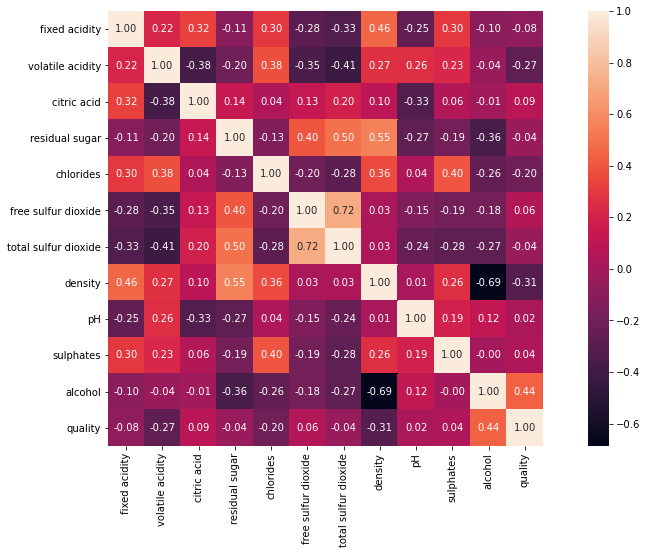

In [20]:
plt.figure(figsize=(16, 8))

wines_corr = wines.corr()
sns.heatmap(wines_corr, annot=True, square=True, fmt='0.2f')

The features most correlated with the quality are:
- alcohol
- density
- volatile acidity

Most of the features are very highly correlated to each other.<br>
We will try to select the best features to avoid redundancies using backward elimination further in the notebook.

### Convert quality label to categorical values

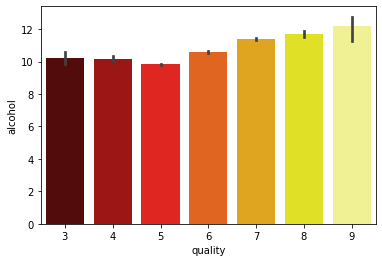

In [21]:
sns.barplot(wines['quality'], wines['alcohol'], palette='hot')

Wines between 7 and 9 quality have a higher alcohol values, we will choose this range for the good wines.<br>
Thus, it looks appropriate to divide the quality label into low, medium and good wines.<br>

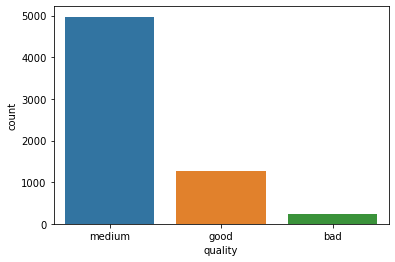

In [22]:
tmp = wines['quality'].values
quality_type = np.empty(tmp.shape, dtype='U6')
quality_type[tmp < 5] = 'bad'
quality_type[(4 < tmp) & (tmp < 7)] = 'medium'
quality_type[6 < tmp] = 'good'

quality_type = pd.DataFrame(columns=['quality'], data=quality_type)
wines = wines.drop('quality', axis=1)
wines = pd.concat([wines.reset_index(drop=True), quality_type.reset_index(drop=True)], axis=1)

sns.countplot(wines.iloc[:, -1])

### Isolate features from the target
Feature scaling is mandatory when using a K-nearest neighbors model.<br>
The KNN algorithm has a distance decision based approach to regress or classify an input.<br>
In fact, if some features have higher values than other, they will contribute more in the overall distance calculation thus biasing the outcome.

In [23]:
X = wines.iloc[:, :-1].to_numpy()
y = wines.iloc[:, -1].to_numpy()

### Convert category to integer

In [24]:
y = LabelEncoder().fit_transform(y)

### Split data in train test

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

scaler = StandardScaler() 
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert data to pytorch tensor
X_train = torch.from_numpy(X_train)
X_test = torch.from_numpy(X_test)
y_train = torch.from_numpy(y_train)
y_test = torch.from_numpy(y_test) 

We will use Pytorch for this experiment

### K-Nearest Neighbors
The K-nearest neighbors classifier looks at the $K^{th}$ closest points in the training set of an input $x$<br>
counts how many members of each class are present and returns the empirical fraction as the estimate.
$$\large p(\mathbf{y} = c|\boldsymbol{\mathbf{x}}, D, K) = \frac{1}{K} \sum_{i \in N_K(\boldsymbol{\mathbf{x}}, D)}\mathbb{I}(y_i = c)$$<br>
$$
\large
\mathbb{I}(e) =
\begin{cases}
    1 & \text{if}\;e\;\text{is true}\\
    0 & \text{otherwise}
\end{cases}
$$
where $c$ is the class and $N_K$ are the closest sample of $\boldsymbol{\text{x}}$ in $D$.

In [26]:
def knn(sample, X, y, k_neighbors=10):
    """Instance of K-Nearest Neigbhors model
    
    Args:
        X: A torch tensor for the data.
        y: A torch tensor for the labels.
        k_neighbors: An integer for the number of nearest neighbors
            to consider.
    """
    sample = sample.unsqueeze(1).T
    # Compute the distance with the train set
    dist = (X - sample).pow(2).sum(axis=1).sqrt()
    
    # Sort the distances
    _, indices = torch.sort(dist)
    y = y[indices]
    
    # Get the Kth most similar samples and return the predominant class
    return y[:k_neighbors].bincount().argmax().item()

In [27]:
def train_knn(X_train, X_test, y_train, y_test, k_neighbors=1):
    """Trains a K-Nearest Neigbhors model 
    
    Args:
        X_train: A torch tensor for the training data.
        X_test: A torch tensor for the test data.
        y_train: A torch tensor for the training labels.
        y_test: A torch tensor for the test labels.
        k_neighbors: An integer for the number of nearest neighbors
            to consider.
    """
    # Allocate space for the prediction
    y_pred_test = np.zeros(y_test.shape, dtype=np.uint8)
    y_pred_train = np.zeros(y_train.shape, dtype=np.uint8)
    X_train_c = X_train.clone()
    
    # Predict on each sample of the train and test
    for i in range(X_test.shape[0]):
        y_pred_test[i] = knn(X_test[i], X_train, y_train, k_neighbors=k_neighbors)
    y_pred_test = torch.from_numpy(y_pred_test).float()
    return y_pred_test

In [28]:
pred_test = train_knn(X_train, X_test, y_train, y_test, k_neighbors=1)
print(classification_report(y_test, pred_test))

# Save data for future visualization
X_train_viz = X_train
X_test_viz = X_test
y_train_viz = y_train
y_test_viz = y_test

              precision    recall  f1-score   support

           0       0.39      0.17      0.24        53
           1       0.65      0.67      0.66       252
           2       0.88      0.90      0.89       995

    accuracy                           0.83      1300
   macro avg       0.64      0.58      0.60      1300
weighted avg       0.82      0.83      0.82      1300



The KNN achieves a good performance compared to its simplicity.<br>

### Exploratory Data Analysis
Let's try to discard some features based on p-value but to see if it improves the results.<br/>
More on p-value here:<br/>
https://www.statsdirect.com/help/basics/p_values.htm#:~:text=The%20P%20value%2C%20or%20calculated,the%20hypothesis%20is%20being%20tested.

In [29]:
columns = wines.columns[:-1]
while len(columns) > 0:
    pvalues = []
    X_1 = wines[columns]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(y, X_1).fit()
    pvalues = pd.Series(model.pvalues[1:], index=columns)
    max_idx = np.argmax(pvalues)
    max_pval = pvalues[max_idx]
    if max_pval > 0.10:
        columns = columns.drop(columns[max_idx]) 
        print('Dropping column ' + columns[max_idx] + ', pvalue is: ' + str(max_pval))
    else:
        break

Dropping column residual sugar, pvalue is: 0.6594184624811075
Dropping column total sulfur dioxide, pvalue is: 0.40799376734207193
Dropping column total sulfur dioxide, pvalue is: 0.16949863758492337


In [30]:
columns

Index(['fixed acidity', 'volatile acidity', 'residual sugar',
       'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol'],
      dtype='object')

In [31]:
X = wines[columns].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
X_train = torch.from_numpy(X_train)
X_test = torch.from_numpy(X_test)
y_train = torch.from_numpy(y_train)
y_test = torch.from_numpy(y_test) 

y_pred = train_knn(X_train, X_test, y_train, y_test, k_neighbors=1)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.14      0.14      0.14        58
           1       0.53      0.53      0.53       308
           2       0.86      0.86      0.86      1259

    accuracy                           0.77      1625
   macro avg       0.51      0.51      0.51      1625
weighted avg       0.77      0.77      0.77      1625



Feature selection based on p-value made the performance worse. From 83% to 77%.<br>
We tested with a value $k \in [1, 10]$ and the best result is given $k = 1$.

### Feature Selection by hand
Let's try to select all the feature that has more than $0.10$ correlation with the target.

In [32]:
columns = ['alcohol', 'density', 'chlorides', 'volatile acidity']

X = wines[columns].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
X_train = torch.from_numpy(X_train)
X_test = torch.from_numpy(X_test)
y_train = torch.from_numpy(y_train)
y_test = torch.from_numpy(y_test) 

y_pred = train_knn(X_train, X_test, y_train, y_test, k_neighbors=1)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.19      0.17      0.18        58
           1       0.51      0.51      0.51       308
           2       0.85      0.86      0.85      1259

    accuracy                           0.77      1625
   macro avg       0.52      0.51      0.51      1625
weighted avg       0.76      0.77      0.77      1625



Same result as backward elimination.<br>
Sometimes all the features are relevant for a given model.

### Conclusion
The K-nearest neighbors algorithm is a simple but rather effective approach in some contexts.<br>
The KNN method has no training step which is very handy when we have an increasing amount of data.<br>
In fact, it is not required to train the KNN model.<br>
However, KNN is not a model to pick when the data has a high dimentionality. Computing the neighbor distances accross a large number of dimension is not effective. This phenomena is also called the "curse of dimensionality".<br>
The KNN model is also uneffective when dealing with outliers. 